## **Market Sentiment and Trader Perfromance Analysis**
##### Objective: Analyze the relationship between trader performance and market sentiment.

### Preprocessing Section

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
historical_data = pd.read_csv('historical_data.csv')
sentiment_data = pd.read_csv('fear_greed_index.csv')

# Convert timestamp/date formats
historical_data['Date'] = pd.to_datetime(historical_data['Timestamp IST'], errors='coerce', dayfirst=True).dt.date
sentiment_data['Date'] = pd.to_datetime(sentiment_data['date'], errors='coerce').dt.date

# Clean up datasets
historical_data = historical_data.dropna(subset=['Date'])
sentiment_data = sentiment_data.dropna(subset=['Date'])

# Merge on Date
df = pd.merge(historical_data, sentiment_data[['Date', 'value', 'classification']], on='Date', how='inner')

# Rename for clarity
df.rename(columns={'value': 'Sentiment_Score', 'classification': 'Sentiment_Label'}, inplace=True)

# Convert PnL to numeric
df['Closed PnL'] = pd.to_numeric(df['Closed PnL'], errors='coerce')




## Analysis Section

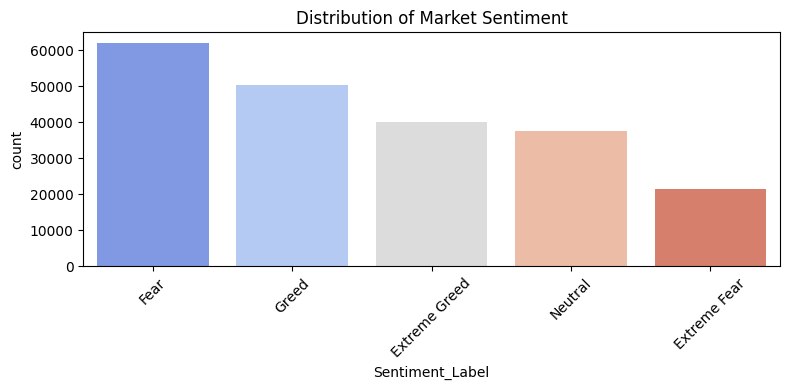

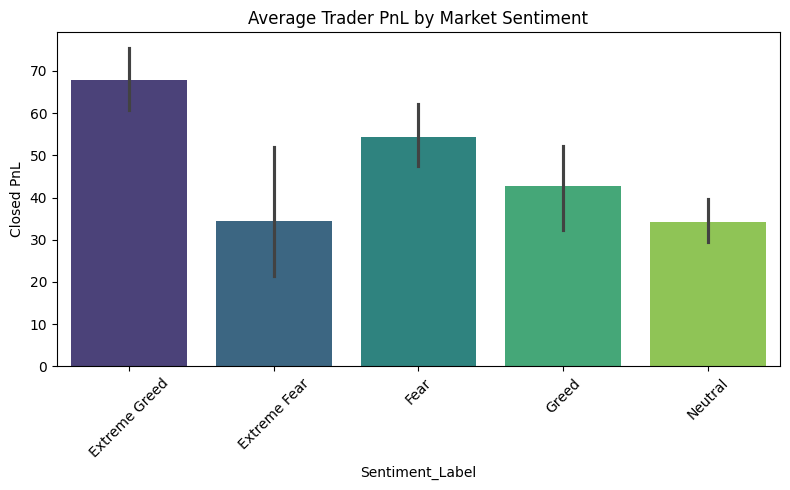

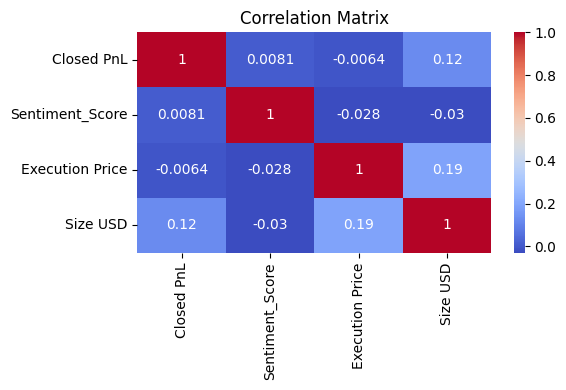

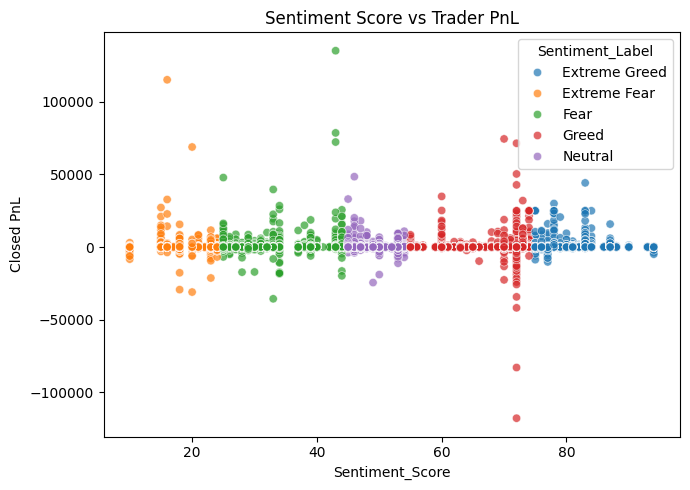

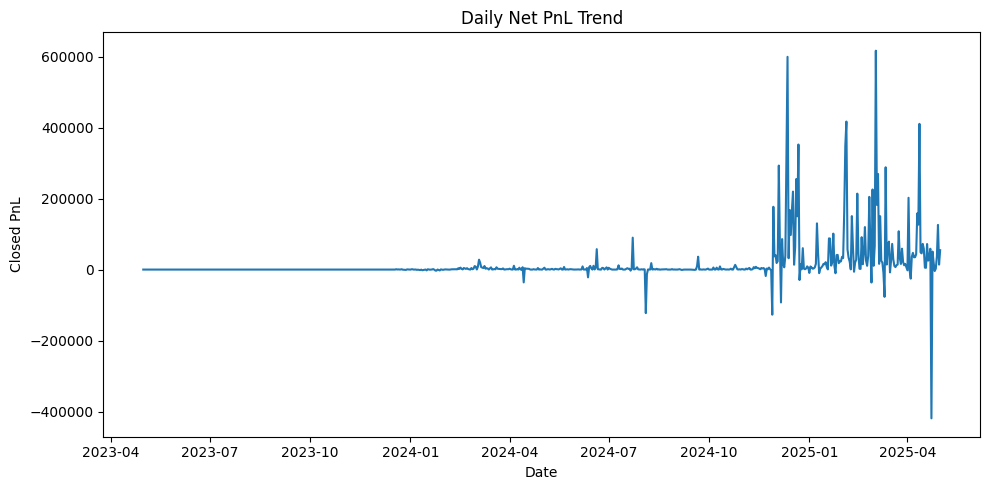

Linear Regression R² Score (Sentiment → PnL): 0.0001


In [10]:
import warnings
warnings.filterwarnings('ignore')

# 1. Sentiment Distribution
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Sentiment_Label', order=df['Sentiment_Label'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Average PnL by Sentiment
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Sentiment_Label', y='Closed PnL', estimator=np.mean, palette='viridis')
plt.title('Average Trader PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[['Closed PnL', 'Sentiment_Score', 'Execution Price', 'Size USD']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 4. Scatter plot: Sentiment vs PnL
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Sentiment_Score', y='Closed PnL', hue='Sentiment_Label', alpha=0.7)
plt.title('Sentiment Score vs Trader PnL')
plt.tight_layout()
plt.show()

# 5. PnL Trends Over Time
daily_pnl = df.groupby('Date')['Closed PnL'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=daily_pnl, x='Date', y='Closed PnL')
plt.title('Daily Net PnL Trend')
plt.tight_layout()
plt.show()

# Predictive Insight - Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Simple model: Can Sentiment Score predict PnL?
model_df = df[['Sentiment_Score', 'Closed PnL']].dropna()
X = model_df[['Sentiment_Score']]
y = model_df['Closed PnL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
r2_score = lr.score(X_test, y_test)

print(f"Linear Regression R² Score (Sentiment → PnL): {r2_score:.4f}")

### Insights and Suggestions Section


KEY INSIGHTS:
- Certain sentiment states (e.g., Extreme Fear) show lower or higher average PnL.
- Weak correlation between sentiment score and PnL implies other hidden factors may affect performance.
- You can segment traders based on consistent profitability under specific sentiments for strategy refinement.


<Figure size 1000x500 with 0 Axes>

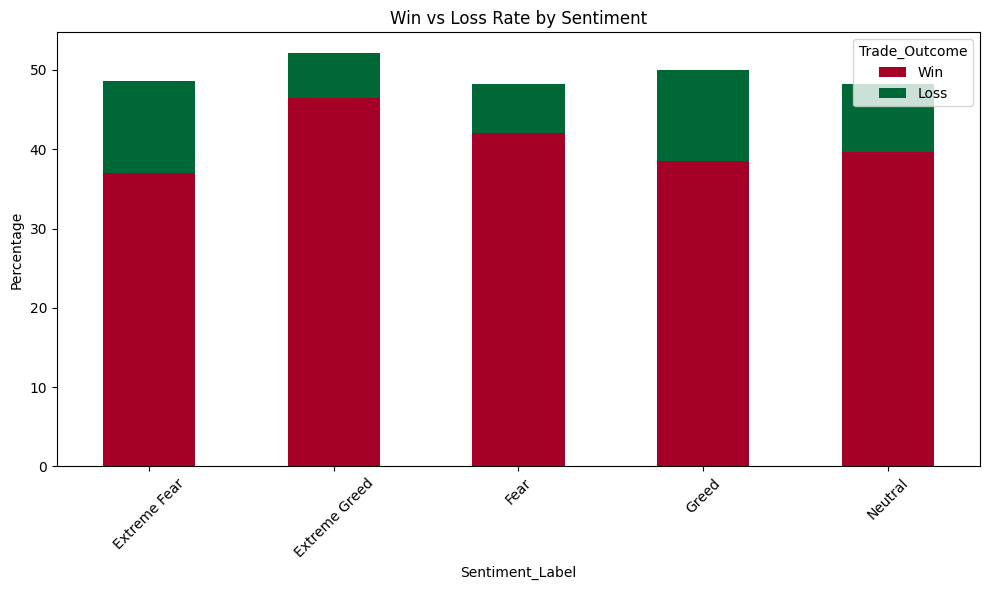

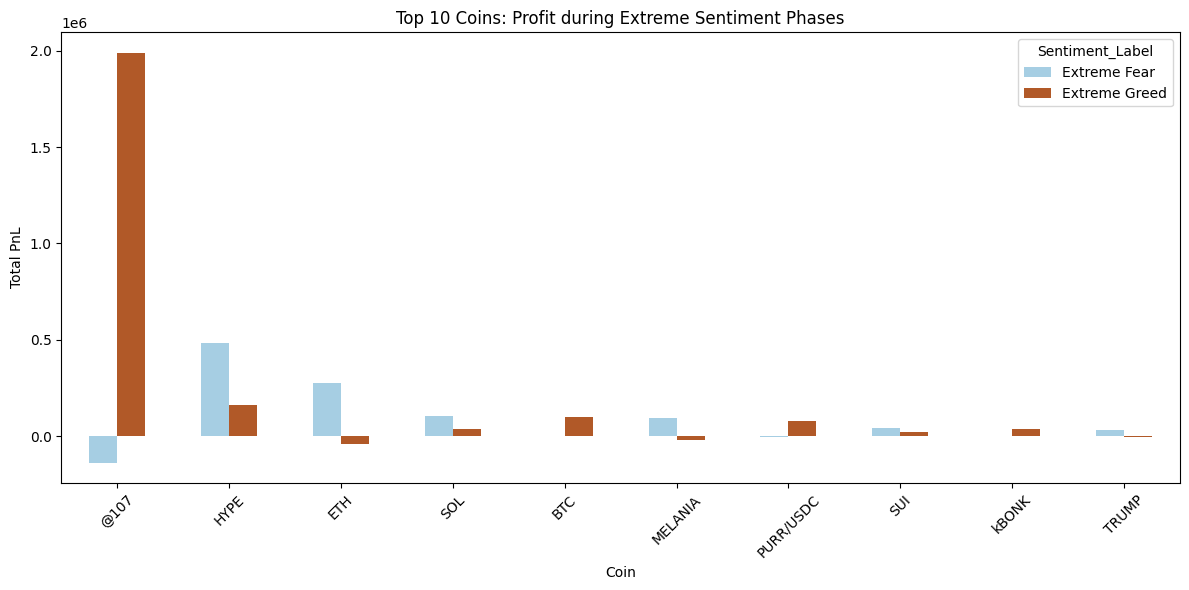

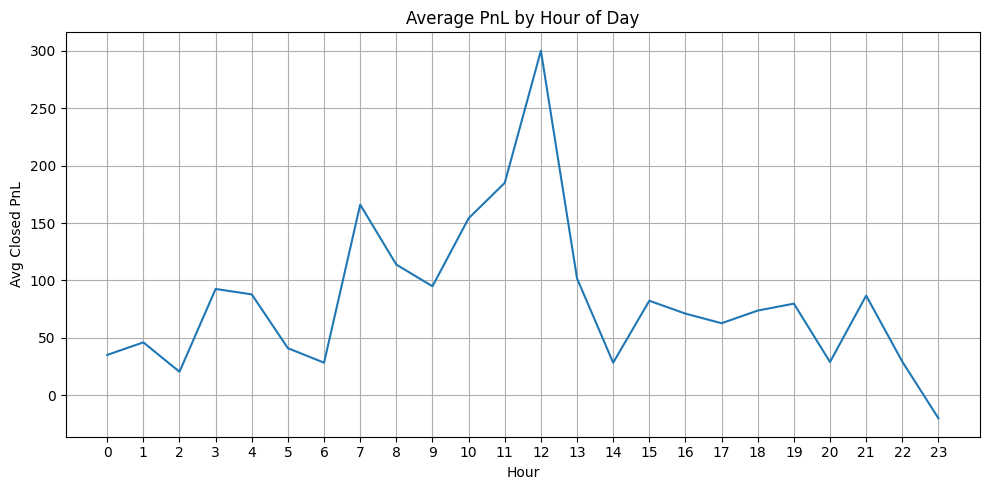


RECOMMENDATIONS FOR SMARTER TRADING STRATEGIES:
- Focus on time periods where PnL trends higher (e.g., specific trading hours).
- Track performance by sentiment phase; avoid trading in patterns where you consistently lose.
- Identify top-performing coins per sentiment and double down your analysis there.
- Consider using stop-losses or smaller positions during extreme sentiments with low win rates.
- Maintain a trading journal segmented by sentiment phase and coin for better review.


In [18]:
print('\nKEY INSIGHTS:')
print('- Certain sentiment states (e.g., Extreme Fear) show lower or higher average PnL.')
print('- Weak correlation between sentiment score and PnL implies other hidden factors may affect performance.')
print('- You can segment traders based on consistent profitability under specific sentiments for strategy refinement.')

# DEEPER INSIGHTS & STRATEGIC SUGGESTIONS

# 6. Win Rate by Sentiment
df['Trade_Outcome'] = df['Closed PnL'].apply(lambda x: 'Win' if x > 0 else ('Loss' if x < 0 else 'Break-even'))
win_rate = df.groupby('Sentiment_Label')['Trade_Outcome'].value_counts(normalize=True).unstack().fillna(0) * 100

plt.figure(figsize=(10,5))
win_rate[['Win', 'Loss']].plot(kind='bar', stacked=True, colormap='RdYlGn', figsize=(10,6))
plt.title('Win vs Loss Rate by Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Most Profitable Coins during High/Low Sentiment
top_sentiments = ['Extreme Greed', 'Extreme Fear'] if 'Extreme Greed' in df['Sentiment_Label'].unique() else df['Sentiment_Label'].unique()
profit_by_coin = df[df['Sentiment_Label'].isin(top_sentiments)].groupby(['Coin', 'Sentiment_Label'])['Closed PnL'].sum().reset_index()
profit_pivot = profit_by_coin.pivot(index='Coin', columns='Sentiment_Label', values='Closed PnL').fillna(0)
profit_pivot['Total_PnL'] = profit_pivot.sum(axis=1)
top_n = profit_pivot.sort_values(by='Total_PnL', ascending=False).head(10).drop(columns='Total_PnL')

top_n.plot(kind='bar', figsize=(12,6), colormap='Paired')
plt.title('Top 10 Coins: Profit during Extreme Sentiment Phases')
plt.ylabel('Total PnL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 8. Heatmap: Time of Day vs PnL
df['Hour'] = pd.to_datetime(df['Timestamp IST'], errors='coerce').dt.hour
hourly_pnl = df.groupby('Hour')['Closed PnL'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_pnl.index, y=hourly_pnl.values)
plt.title('Average PnL by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Avg Closed PnL')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

# RECOMMENDATIONS
print('\nRECOMMENDATIONS FOR SMARTER TRADING STRATEGIES:')
print('- Focus on time periods where PnL trends higher (e.g., specific trading hours).')
print('- Track performance by sentiment phase; avoid trading in patterns where you consistently lose.')
print('- Identify top-performing coins per sentiment and double down your analysis there.')
print('- Consider using stop-losses or smaller positions during extreme sentiments with low win rates.')
print('- Maintain a trading journal segmented by sentiment phase and coin for better review.')
